In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
import utils
from dateutil.parser import parse
from datetime import date, timedelta


np.set_printoptions(threshold=50, edgeitems=20)

import utils

# Data fetching

In [3]:
PATH = "data/" # "../../../data/RRVF/" "/data/"
RESULT = "result/"

In [4]:
!ls {PATH}

1-1-16_5-31-17_Weather.zip
air_reserve.csv
air_station_distances.csv
air_store_info.csv
air_store_info_with_nearest_active_station.csv
air_visit_data.csv
date_info.csv
feature_manifest.csv
hpg_reserve.csv
hpg_station_distances.csv
hpg_store_info.csv
hpg_store_info_with_nearest_active_station.csv
models
nearby_active_stations.csv
rrv-weather-data.zip
sample_submission.csv
store_id_relation.csv
tmp
ts_prep.pkl
weather_data_merge.csv
weather_stations.csv


In [5]:
splits = pickle.load(open(f'{RESULT}_datasplits.pkl','rb'))
contin_vars = splits['contin_vars']
cat_vars = splits['cat_vars']
X_train = splits['trn']
y_train = splits['trn_y']
X_valid = splits['val']
y_valid = splits['val_y']
X_test = splits['test']

# Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def generate_sub(csv_fn, m, df_test):
    pred_test= m.predict(df_test)
    pred_test = np.exp(pred_test)
    test_set['visitors']=pred_test
    trn_like_test = test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']]
    trn_like_test.visit_date = trn_like_test.visit_date.astype('str')
    sub = utils.trn2test(trn_like_test)
    sub.to_csv(csv_fn, index=False)

In [7]:
set_rf_samples(50000)

In [8]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.4391320808417637, 0.5100765331096846, 0.70343780158622971, 0.61670034633252691, 0.57565926933857947]


In [11]:
m = RandomForestRegressor(n_estimators=55, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.4534025102144126, 0.5064660276988415, 0.68384991602011569, 0.62210740779621987, 0.58007803367154787]


In [130]:


generate_sub('yy_split_sample.csv', m, df_test)

In [36]:
reset_rf_samples()

In [37]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2673434892587321, 0.5126637835121219, 0.89008304593489351, 0.61280207935372966, 0.55459379384574037]


In [150]:
generate_sub('yy_split_full.csv', m, df_test)

# For Validation only

In [181]:
trn = data['tra']

In [182]:
trn_like_test = test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']]
trn_like_test.visit_date = trn_like_test.visit_date.astype('str')
sub = utils.trn2test(trn_like_test)

In [184]:
sub.visitors = trn.visitors.mean()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [185]:
sub.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,20.973761
1,air_00a91d42b08b08d9_2017-04-24,20.973761
2,air_00a91d42b08b08d9_2017-04-25,20.973761
3,air_00a91d42b08b08d9_2017-04-26,20.973761
4,air_00a91d42b08b08d9_2017-04-27,20.973761


In [189]:
rmse(np.log1p(20.973761), y_valid)

0.8690054253642328

In [190]:
sub.to_csv('all_mean', index=False)

In [194]:
result = trn.groupby('air_store_id').mean().reset_index()

In [199]:
agg = pd.merge(valid_set[['air_store_id']].reset_index(), result)

In [201]:
# agg.head()
rmse(np.log1p(agg.visitors.values), y_valid)

0.6285172436351284

In [206]:
agg = pd.merge(trn_like_test[['air_store_id', 'visit_date']], result)
sub = utils.trn2test(agg)
sub.to_csv('grp_mean', index=False)

In [208]:
x = [0.5659305848785533, 0.5481404729410964, 0.8690054253642328, 0.6285172436351284]
y = [0.618 , 0.605, 0.886, 0.634]

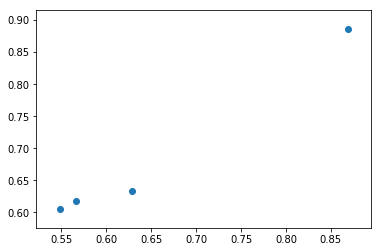

In [209]:
plt.scatter(x, y )

Yang's split is a good default

In [13]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
37,rolling_air_store_id_visit_Dayofweek_90d_mean,0.317518
76,rolling_air_store_id_visit_Dayofweek_90d_median,0.114667
52,rolling_air_store_id_visit_Dayofweek_180d_mean,0.091479
75,rolling_air_store_id_visit_Dayofweek_60d_mean,0.060703
40,rolling_air_store_id_30d_median,0.019544
85,rolling_air_store_id_30d_mean,0.017957
94,rolling_air_store_id_visit_Dayofweek_180d_median,0.016489
68,rolling_air_store_id_visit_Dayofweek_360d_median,0.014629
9,be_holiday_flg,0.010887
35,rolling_air_store_id_visit_Dayofweek_360d_mean,0.010544


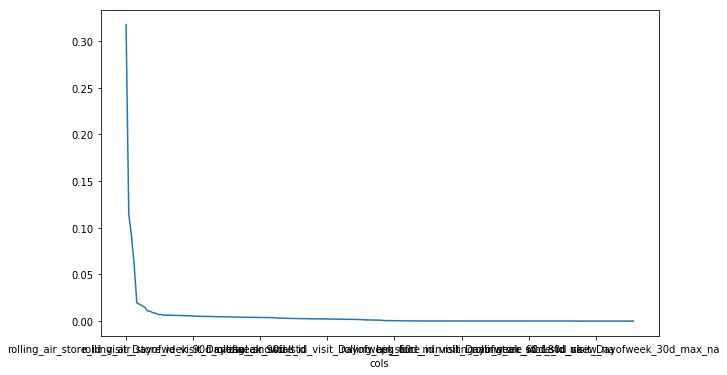

In [14]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [15]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

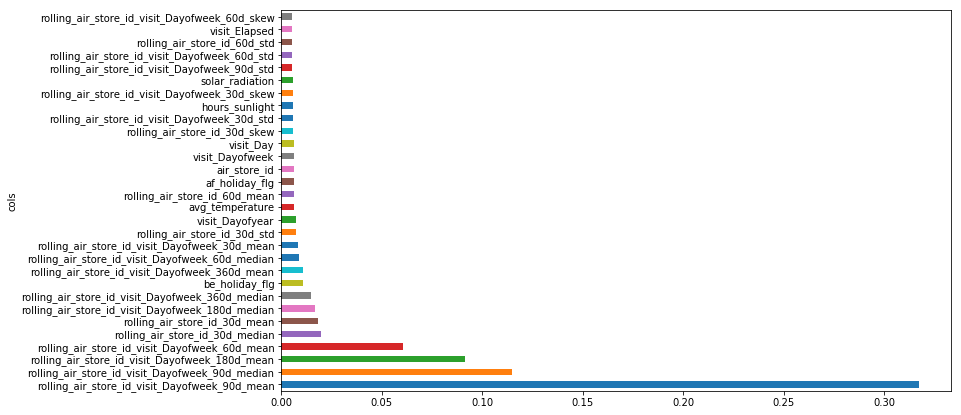

In [16]:
plot_fi(fi[:30]);

In [115]:
to_keep = fi[fi.imp>0.005].cols; 
to_keep = list(set(to_keep) - set(["visit_Dayofyear"]))
len(to_keep)

27

In [116]:
X_train, X_valid = df[to_keep].copy(), df_val[to_keep].copy()

In [124]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.46817773054768813, 0.5664348115425176, 0.66290914916122134, 0.52731958101897236, 0.55586476982507405]


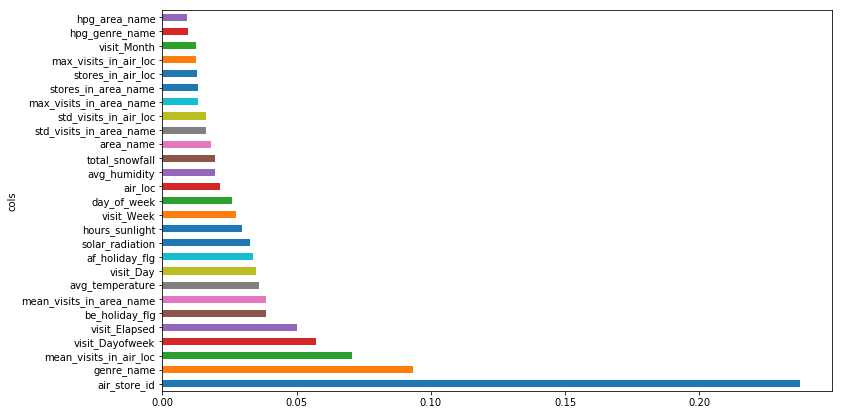

In [125]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi);

In [128]:
from sklearn.externals import joblib
joblib.dump(m, '{PATH}1st.pkl') 

['{PATH}1st.pkl']

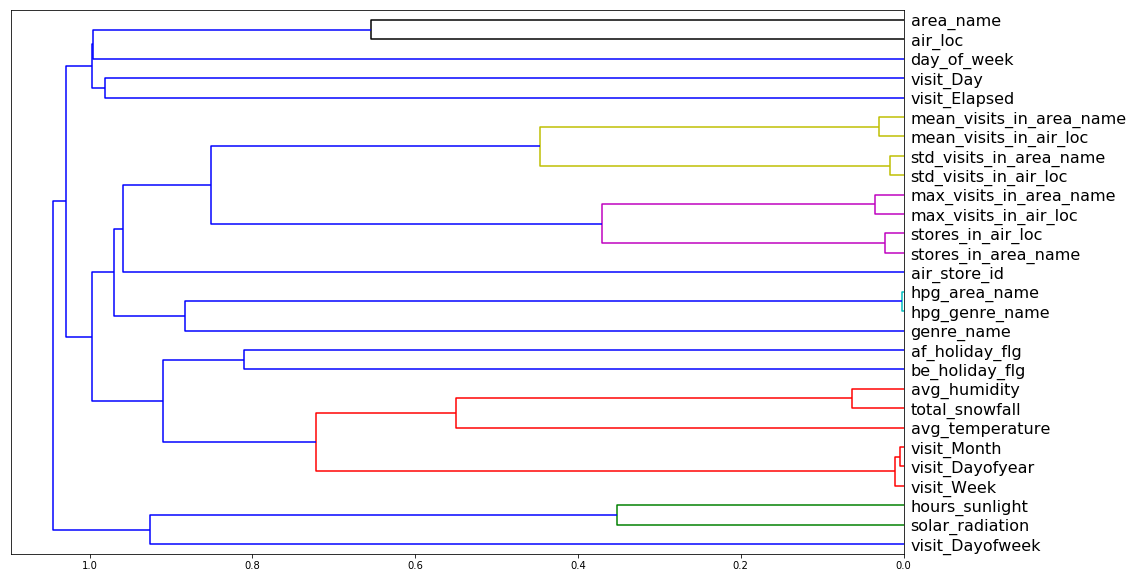

In [111]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [112]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y_train)
    return m.oob_score_

In [113]:
get_oob(X_train)

0.54944460285766084

In [114]:
for c in ('hpg_area_name', 'hpg_genre_name','visit_Month', 'visit_Dayofyear'):
    print(c, get_oob(X_train.drop(c, axis=1)))

hpg_area_name 0.548242842795
hpg_genre_name 0.550920167942
visit_Month 0.549747122541
visit_Dayofyear 0.548202994228


In [33]:
reset_rf_samples()

In [34]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.36179922521130875, 0.676993103351176, 0.79869214280979817, 0.32479409983233809, 0.57243590199522287]


# Partial dependence

In [36]:
from pdpbox import pdp
from plotnine import *

In [37]:
set_rf_samples(50000)

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

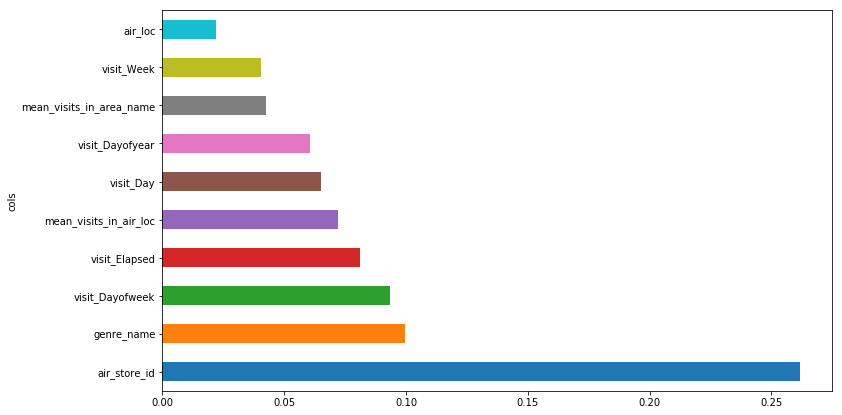

In [41]:
plot_fi(rf_feat_importance(m, X_train)[:10]);

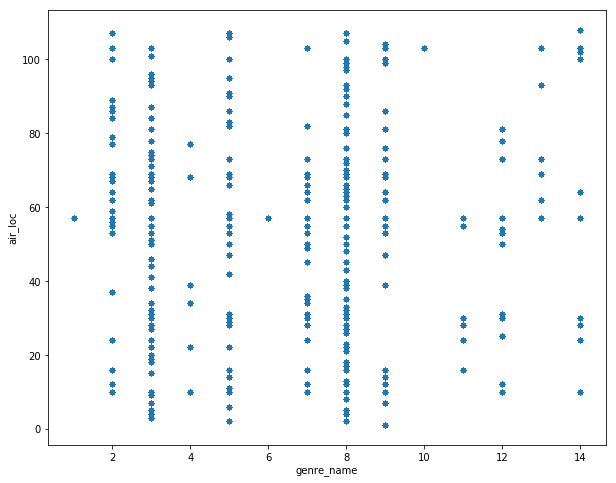

In [46]:
X_train.plot('genre_name', 'air_loc', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [47]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 202 ms, sys: 40.7 ms, total: 243 ms
Wall time: 242 ms


(3.4392016761615194, 0.60899233236474881)

In [48]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 87.4 ms, sys: 80.6 ms, total: 168 ms
Wall time: 304 ms


(3.4392016761615194, 0.60899233236474881)

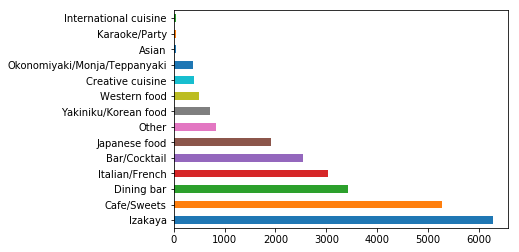

In [51]:
x = valid_set.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.genre_name.value_counts().plot.barh();

In [54]:
flds = ['genre_name', 'visitors', 'pred', 'pred_std']
enc_summ = x[flds].groupby('genre_name', as_index=False).mean()
enc_summ

,genre_name,visitors,pred,pred_std
0,Asian,37.127273,2.873264,0.796646
1,Bar/Cocktail,13.279608,2.368110,0.602758
2,Cafe/Sweets,23.337569,3.009520,0.630609
3,Creative cuisine,26.486005,3.062032,0.648814
4,Dining bar,18.820835,2.752250,0.683347
5,International cuisine,26.410256,2.933772,0.870651
6,Italian/French,22.712401,2.970162,0.696028
7,Izakaya,23.771219,2.970354,0.631278
8,Japanese food,19.475616,2.883718,0.683474
9,Karaoke/Party,34.641509,3.081506,0.740399


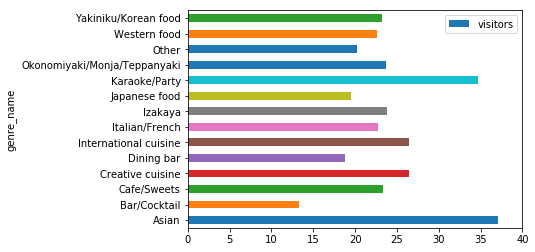

In [58]:
enc_summ = enc_summ[~pd.isnull(enc_summ.genre_name)]
enc_summ.plot('genre_name', 'visitors', 'barh', xlim=(0,40));

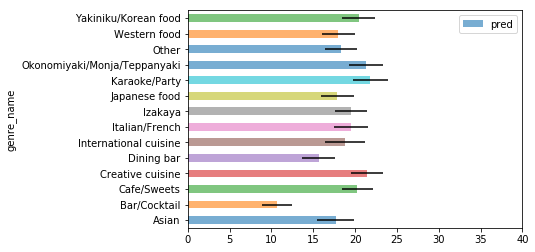

In [63]:

enc_summ.plot('genre_name', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,40));

In [ ]:
enc_summ.pred = np.exp(enc_summ.pred)

In [62]:
enc_summ.pred_std = np.exp(enc_summ.pred_std)

In [64]:
(enc_summ.pred_std/enc_summ.pred).sort_values(ascending=False)

1     0.171126
5     0.127057
4     0.126324
0     0.125353
8     0.110776
12    0.110359
11    0.104088
6     0.102886
7     0.096417
9     0.096221
13    0.095343
10    0.095107
2     0.092651
3     0.089527
dtype: float64

In [65]:
enc_summ

,genre_name,visitors,pred,pred_std
0,Asian,37.127273,17.694677,2.218089
1,Bar/Cocktail,13.279608,10.677196,1.827150
2,Cafe/Sweets,23.337569,20.277655,1.878754
3,Creative cuisine,26.486005,21.370933,1.913270
4,Dining bar,18.820835,15.677862,1.980495
5,International cuisine,26.410256,18.798410,2.388465
6,Italian/French,22.712401,19.495079,2.005771
7,Izakaya,23.771219,19.498812,1.880011
8,Japanese food,19.475616,17.880624,1.980747
9,Karaoke/Party,34.641509,21.791195,2.096772


# Tree interpreter


In [67]:
from treeinterpreter import treeinterpreter as ti

In [68]:
row = X_valid.values[None,0]; row

array([[   1.     ,    7.     ,    6.     ,  450.     ,    1.83413,   25.     ,   84.     ,    1.88624,
          12.     ,   69.     ,   45.     ,    1.40543,    1.42265,    3.     ,   -0.68605,   -0.18596,
          -0.67694,   -0.1581 ,    0.     ,   35.     ,    0.     ]])

In [69]:
prediction, bias, contributions = ti.predict(m, row)

In [70]:
prediction[0], bias[0]

(3.4392016761615194, 2.8002709957732206)

In [71]:
idxs = np.argsort(contributions[0])

In [73]:
[o for o in zip(X_train.columns[idxs], X_train.iloc[0][idxs], contributions[0][idxs])]

[('visit_Elapsed', 183.0, -0.071514926613036184),
 ('air_loc', 69.0, -0.016864963159615231),
 ('stores_in_air_loc', -0.15810222944651017, -0.012196819936200165),
 ('area_name', 45.0, -0.011989975220242621),
 ('visit_Dayofyear', 183.0, -0.0051088356225353349),
 ('hpg_genre_name', 0.0, 0.0034689967357795061),
 ('std_visits_in_area_name', 0.9717744944336782, 0.0083173268337478519),
 ('hpg_loc', 35.0, 0.012676410884746914),
 ('max_visits_in_air_loc', -0.5084147876939403, 0.013161828844448598),
 ('stores_in_area_name', -0.18596131089351278, 0.014877503610547427),
 ('genre_name', 7.0, 0.015185691376606358),
 ('visit_Month', 7.0, 0.015746843540219858),
 ('visit_Day', 1.0, 0.016314787128898268),
 ('visit_Week', 26.0, 0.020107236634243318),
 ('std_visits_in_air_loc', 0.964317762725145, 0.023366772205020658),
 ('air_store_id', 1.0, 0.025112464677193413),
 ('hpg_area_name', 0.0, 0.035259543478246724),
 ('max_visits_in_area_name', -0.5185350940077101, 0.036990592214938833),
 ('mean_visits_in_area_

In [74]:
contributions[0].sum()

0.63893068038829837

# Extrapolation

In [80]:
df_ext = pd.concat((X_train.copy(), X_valid.copy()))
df_ext['is_valid'] = 1
df_ext.is_valid[:len(X_train)] = 0
x, y, _ = proc_df(df_ext, 'is_valid')

In [81]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9988541450404842

In [82]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
3,visit_Elapsed,0.607622
6,visit_Dayofyear,0.082584
8,visit_Week,0.057169
14,max_visits_in_area_name,0.053746
16,max_visits_in_air_loc,0.041384
17,stores_in_air_loc,0.037159
13,visit_Month,0.026922
15,stores_in_area_name,0.020840
11,std_visits_in_air_loc,0.019514
12,std_visits_in_area_name,0.016232


In [83]:
feats=['visit_Elapsed', 'visit_Dayofyear', 'visit_Week']

In [84]:
(X_train[feats]/1000).describe()

,visit_Elapsed,visit_Dayofyear,visit_Week
count,225049.000000,225049.000000,225049.000000
mean,0.267299,0.182896,0.026270
std,0.114545,0.115288,0.016392
min,0.001000,0.001000,0.001000
25%,0.196000,0.062000,0.009000
50%,0.279000,0.202000,0.029000
75%,0.359000,0.285000,0.041000
max,0.476000,0.366000,0.053000


In [85]:
(X_valid[feats]/1000).describe()

,visit_Elapsed,visit_Dayofyear,visit_Week
count,25419.000000,25419.000000,25419.000000
mean,0.430037,0.093751,0.013671
std,0.110584,0.015042,0.002156
min,0.000000,0.035000,0.005000
25%,0.449000,0.085000,0.012000
50%,0.458000,0.095000,0.014000
75%,0.468000,0.104000,0.015000
max,0.476000,0.363000,0.052000


In [86]:
x.drop(feats, axis=1, inplace=True)

In [87]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99990018685021642

In [88]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,visit_Month,0.331620
11,max_visits_in_area_name,0.163644
13,max_visits_in_air_loc,0.117868
14,stores_in_air_loc,0.107236
9,std_visits_in_area_name,0.056961
12,stores_in_area_name,0.049920
8,std_visits_in_air_loc,0.046896
5,mean_visits_in_area_name,0.037133
3,mean_visits_in_air_loc,0.028752
6,air_loc,0.025400


In [89]:
feats=['visit_Elapsed', 'visit_Dayofyear', 'visit_Week', 'visit_Month', 'max_visits_in_area_name']

In [91]:
for f in feats:
    df_subs = X_train.drop(f, axis=1).copy()
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df_subs, y_train)
    print(f)
    print_score(m)

visit_Elapsed


ValueError: Number of features of the model must match the input. Model n_features is 20 and input n_features is 21 

# DL

In [6]:
yl, df, y2, df_val, df_test = y_train, X_train, y_valid, X_valid, X_test

In [7]:
def inv_y(a): return np.exp(a)

def rmsle(y_pred, targ):
#     targ = inv_y(targ)
    log_vars = targ - y_pred
    return math.sqrt(np.square(log_vars).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [9]:
md = ColumnarModelData.from_data_frames(PATH, df, df_val, yl.astype(np.float32), y2.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [10]:
cat_sz = [(c, len(df[c].unique())+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [11]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [12]:
m.lr_find()


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 96%|█████████▌| 1682/1759 [00:48<00:02, 34.45it/s, loss=1.3]] 

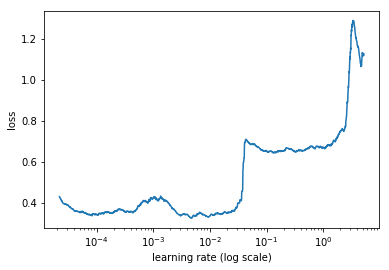

 96%|█████████▌| 1682/1759 [01:00<00:02, 28.01it/s, loss=1.3]

In [13]:
m.sched.plot(100)

In [14]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4/1.1

In [15]:
m.fit(lr, 3, metrics=[rmsle])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  5%|▌         | 94/1759 [00:03<01:04, 25.84it/s, loss=0.427]


 11%|█         | 190/1759 [00:06<00:52, 29.62it/s, loss=0.356]


 16%|█▋        | 290/1759 [00:09<00:46, 31.55it/s, loss=0.33]


 17%|█▋        | 302/1759 [00:09<00:45, 32.09it/s, loss=0.33] 

KeyboardInterrupt: 

In [36]:
lr = 1e-4
m.fit(lr, 20, metrics=[rmsle], cycle_len=3, cycle_mult=1)

KeyboardInterrupt: 

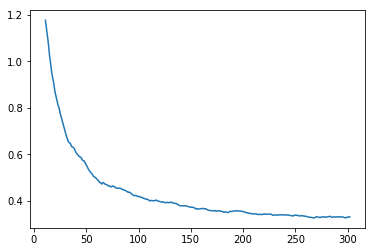

In [17]:
m.sched.plot_loss()

In [20]:
x,y=m.predict_with_targs()
rmsle(x,y)

0.5354620623609236

In [19]:
x,y=m.predict_with_targs()

In [28]:
contin_vars


['prop_yhat_lower',
 'prop_yhat_upper',
 'prop_yhat',
 'stores_in_air_loc',
 'stores_in_hpg_loc',
 'stores_in_area_name',
 'stores_in_hpg_area_name',
 'min_visits_in_air_store_id',
 'max_visits_in_air_store_id',
 'mean_visits_in_air_store_id',
 'std_visits_in_air_store_id',
 'min_visits_in_air_loc',
 'max_visits_in_air_loc',
 'mean_visits_in_air_loc',
 'std_visits_in_air_loc',
 'min_visits_in_hpg_loc',
 'max_visits_in_hpg_loc',
 'mean_visits_in_hpg_loc',
 'std_visits_in_hpg_loc',
 'min_visits_in_area_name',
 'max_visits_in_area_name',
 'mean_visits_in_area_name',
 'std_visits_in_area_name',
 'min_visits_in_hpg_area_name',
 'max_visits_in_hpg_area_name',
 'mean_visits_in_hpg_area_name',
 'std_visits_in_hpg_area_name']

In [34]:
cat_sz


[('air_store_id', 822),
 ('visit_Year', 3),
 ('visit_Month', 13),
 ('visit_Week', 54),
 ('visit_Day', 32),
 ('visit_Dayofweek', 8),
 ('visit_Dayofyear', 367),
 ('visit_Is_month_end', 3),
 ('visit_Is_month_start', 3),
 ('visit_Is_quarter_end', 3),
 ('visit_Is_quarter_start', 3),
 ('visit_Is_year_end', 3),
 ('visit_Is_year_start', 3),
 ('visit_Elapsed', 477),
 ('day_of_week', 8),
 ('holiday_flg', 3),
 ('af_holiday_flg', 75),
 ('be_holiday_flg', 75),
 ('dur_time_holiday_flg', 8),
 ('dur_holiday_flg', 6),
 ('dur_prog_holiday_flg', 8),
 ('genre_name', 15),
 ('area_name', 72),
 ('hpb_genre_name', 16),
 ('hpb_area_name', 33),
 ('air_loc', 74),
 ('hpb_loc', 34)]

In [387]:
csv_fn=f'sub1.csv'
pred_test=m.predict(True)
pred_test = np.exp(pred_test)
test_set['visitors']=pred_test
sub = utils.trn2test(test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']])
sub.to_csv(csv_fn, index=False)

In [388]:
FileLink(csv_fn)


/notebooks/sub1.csv

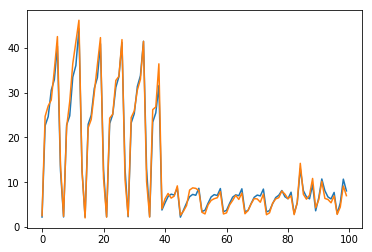

In [326]:
plt.plot(test_set.prop_yhat.values[:100])
plt.plot(pred_test[:100])

In [95]:
np.exp(0.044)

1.0449823548884438

In [96]:
np.exp(np.log1p(30) - 0.044)

29.665572681664447